## 1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work. a

In [12]:
import numpy as np
import h5py

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(5.0,4.0)  # Set default sizes of plots
plt.rcParams['image.interpolation']='nearest'
plt.rcParams['image.cmap']='gray'

%load_ext autoreload
np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2 - Outline of the Assignment

You will be implementing the building blocks of a convolutional neural network! Each function you will implement will have detailed instructions that will walk you through the steps needed:

- Convolution functions, including:
    - Zero Padding
    - Convolve window 
    - Convolution forward
    - Convolution backward (optional)
- Pooling functions, including:
    - Pooling forward
    - Create mask 
    - Distribute value
    - Pooling backward (optional)
    
This notebook will ask you to implement these functions from scratch in `numpy`. In the next notebook, you will use the TensorFlow equivalents of these functions to build the following model:

<img src="images/model.png" style="width:800px;height:300px;">

**Note** that for every forward function, there is its corresponding backward equivalent. Hence, at every step of your forward module you will store some parameters in a cache. These parameters are used to compute gradients during backpropagation. 

## 3 - Convolutional Neural Networks

Although programming frameworks make convolutions easy to use, they remain one of the hardest concepts to understand in Deep Learning. A convolution layer transforms an input volume into an output volume of different size, as shown below. 

<img src="images/conv_nn.png" style="width:350px;height:200px;">

In this part, you will build every step of the convolution layer. You will first implement two helper functions: one for zero padding and the other for computing the convolution function itself. 

### 3.1 - Zero-Padding

Zero-padding adds zeros around the border of an image:

<img src="images/PAD.png" style="width:600px;height:400px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **Zero-Padding**<br> Image (3 channels, RGB) with a padding of 2. </center></caption>

The main benefits of padding are the following:

- It allows you to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks, since otherwise the height/width would shrink as you go to deeper layers. An important special case is the "same" convolution, in which the height/width is exactly preserved after one layer. 

- It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels as the edges of an image.

**Exercise**: Implement the following function, which pads all the images of a batch of examples X with zeros. [Use np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html). Note if you want to pad the array "a" of shape $(5,5,5,5,5)$ with `pad = 1` for the 2nd dimension, `pad = 3` for the 4th dimension and `pad = 0` for the rest, you would do:
```python
a = np.pad(a, ((0,0), (1,1), (0,0), (3,3), (0,0)), mode='constant', constant_values = (0,0))
```

In [14]:
def zero_pad(X,pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    
    """
    X_pad=np.pad(X,((0,0),(pad,pad),(pad,pad),(0,0)),mode='constant',constant_values=(0,0))
    
    return X_pad

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


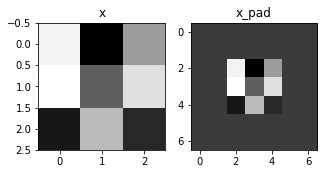

In [17]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1,1])
print ("x_pad[1,1] =\n", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

### 3.2 - Single step of convolution 

In this part, implement a single step of convolution, in which you apply the filter to a single position of the input. This will be used to build a convolutional unit, which: 

- Takes an input volume 
- Applies a filter at every position of the input
- Outputs another volume (usually of different size)

<img src="images/Convolution_schematic.gif" style="width:500px;height:300px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u><font color='purple'>  : **Convolution operation**<br> with a filter of 3x3 and a stride of 1 (stride = amount you move the window each time you slide) </center></caption>

In a computer vision application, each value in the matrix on the left corresponds to a single pixel value, and we convolve a 3x3 filter with the image by multiplying its values element-wise with the original matrix, then summing them up and adding a bias. In this first step of the exercise, you will implement a single step of convolution, corresponding to applying a filter to just one of the positions to get a single real-valued output. 

Later in this notebook, you'll apply this function to multiple positions of the input to implement the full convolutional operation. 

**Exercise**: Implement conv_single_step(). [Hint](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.sum.html).



In [19]:
def conv_single_step(a_slice_prev,W,b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data
    """
    # Element-wise product between a_slice_prev and W. Do not add the bias yet.
    s=np.multiply(a_slice_prev,W)
    
    # Sum all the entries of the Volume S.
    Z=np.sum(s)
    
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z=np.squeeze(Z+np.float32(b))
    
    return Z

In [22]:
# Just a test-case
np.random.seed(1)
a_slice_prev=np.random.randn(4,4,3)
W=np.random.randn(4,4,3)
b=np.random.randn(1,1,1)
Z=conv_single_step(a_slice_prev,W,b)
print(Z)

-6.9990892


### 3.3 - Convolutional Neural Networks - Forward pass

In the forward pass, you will take many filters and convolve them on the input. Each 'convolution' gives you a 2D matrix output. You will then stack these outputs to get a 3D volume: 

<center>
<video width="620" height="440" src="images/conv_kiank.mp4" type="video/mp4" controls>
</video>
</center>

**Exercise**: 
Implement the function below to convolve the filters `W` on an input activation `A_prev`.  
This function takes the following inputs:
* `A_prev`, the activations output by the previous layer (for a batch of m inputs); 
* Weights are denoted by `W`.  The filter window size is `f` by `f`.
* The bias vector is `b`, where each filter has its own (single) bias. 

Finally you also have access to the hyperparameters dictionary which contains the stride and the padding. 

**Hint**: 
1. To select a 2x2 slice at the upper left corner of a matrix "a_prev" (shape (5,5,3)), you would do:
```python
a_slice_prev = a_prev[0:2,0:2,:]
```
Notice how this gives a 3D slice that has height 2, width 2, and depth 3.  Depth is the number of channels.  
This will be useful when you will define `a_slice_prev` below, using the `start/end` indexes you will define.
2. To define a_slice you will need to first define its corners `vert_start`, `vert_end`, `horiz_start` and `horiz_end`. This figure may be helpful for you to find out how each of the corner can be defined using h, w, f and s in the code below.

<img src="images/vert_horiz_kiank.png" style="width:400px;height:300px;">
<caption><center> <u> <font color='purple'> **Figure 3** </u><font color='purple'>  : **Definition of a slice using vertical and horizontal start/end (with a 2x2 filter)** <br> This figure shows only a single channel.  </center></caption>


**Reminder**:
The formulas relating the output shape of the convolution to the input shape is:
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C = \text{number of filters used in the convolution}$$

For this exercise, we won't worry about vectorization, and will just implement everything with for-loops.

#### Additional Hints if you're stuck


* You will want to use array slicing (e.g.`varname[0:1,:,3:5]`) for the following variables:  
  `a_prev_pad` ,`W`, `b`  
  Copy the starter code of the function and run it outside of the defined function, in separate cells.  
  Check that the subset of each array is the size and dimension that you're expecting.  
* To decide how to get the vert_start, vert_end; horiz_start, horiz_end, remember that these are indices of the previous layer.  
  Draw an example of a previous padded layer (8 x 8, for instance), and the current (output layer) (2 x 2, for instance).  
  The output layer's indices are denoted by `h` and `w`.  
* Make sure that `a_slice_prev` has a height, width and depth.
* Remember that `a_prev_pad` is a subset of `A_prev_pad`.  
  Think about which one should be used within the for loops.

In [96]:
def conv_forward(A_prev,W,b,hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    # Retrieve Dimensions from A_prev's shape
    (m,n_H_prev,n_W_prev,n_C_prev)=A_prev.shape[0],A_prev.shape[1],A_prev.shape[2],A_prev.shape[3]
    
    # Retrieve Dimensions from W's shape
    (f,f,n_C_prev,n_C)=W.shape[0],W.shape[1],W.shape[2],W.shape[3]
    
    # Retrieve information from hparameters
    pad=hparameters['pad']
    stride=hparameters['stride']
    
    # Compute the dimensions of the CONV output volume using the formula given above. 
    # Hint: use int() to apply the 'floor' operation. (≈2 lines)
    n_H=int(((n_H_prev+2*pad-f)/stride)+1)
    n_W=int(((n_W_prev+2*pad-f)/stride)+1)
    
    # Initialise the o/p volumen Z with Zeros.
    Z=np.zeros((m,n_H,n_W,n_C))
    
    # Creating A_prev_pad by padding
    A_prev_pad=zero_pad(A_prev,pad)
    
    for i in range(m):  # Loop over the batch of training examples
        a_prev_pad=A_prev_pad[i,:,:,:] # Select the ith training example's padded activation
        for h in range(0,n_H):      # Loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice"
            vert_start=h*stride
            vert_end=vert_start+f
            
            for w in range(0,n_W):  # Loop over horizontal axis of the output Volume
                # Find the horizontal start and end of the current "slice"
                horiz_start=w*stride
                horiz_end=horiz_start+f

                for c in range(n_C):
                    # Use the corners to define the 3D slice of a_prev_pad
                    a_slice_prev=a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron
                    weights=W[:,:,:,c]
                    biases=b[:,:,:,c]
                    Z[i,h,w,c]=conv_single_step(a_slice_prev,weights,biases)
    
    # Making sure your output shape is correct
    assert(Z.shape == (m,n_H,n_W,n_C))
    
    # Save information in "cache" for the backprop
    cache=(A_prev,W,b,hparameters)
    
    return Z,cache

In [97]:
# Checking if the above function is working properly
np.random.seed(1)
A_prev=np.random.randn(10,5,7,4)
W=np.random.randn(3,3,4,8)
b=np.random.randn(1,1,1,8)
hparameters={'stride':2,
             'pad':1}

Z,cache_conv=conv_forward(A_prev,W,b,hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

Z's mean =
 0.6923608928608398
Z[3,2,1] =
 [-1.28912222  2.27650237  6.6194191   0.95527172  8.25132561  2.31329632
 13.00689411  2.34576035]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


**Expected Output**:
```
Z's mean =
 0.692360880758
Z[3,2,1] =
 [ -1.28912231   2.27650251   6.61941931   0.95527176   8.25132576
   2.31329639  13.00689405   2.34576051]
cache_conv[0][1][2][3] = [-1.1191154   1.9560789  -0.3264995  -1.34267579]
```